# Jolideco Analysis of Chandra Data of E0102

In [1]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib as mpl
from astropy.visualization import simple_norm
from astropy.table import Table
from astropy import units as u
from astropy.wcs.wcs import FITSFixedWarning
from jolideco.core import MAPDeconvolver, MAPDeconvolverResult
from jolideco.utils.numpy import split_datasets_validation
from jolideco.models import (
    SpatialFluxComponent,
    FluxComponents,
    NPredCalibration,
    NPredCalibrations,
    NPredModels,
)
from jolideco.priors import GMMPatchPrior, GaussianMixtureModel
from jolideco.utils.norms import IdentityImageNorm
from itertools import zip_longest
from gammapy.maps import Map
import torch
import yaml
from dateutil import parser

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FITSFixedWarning)

In [3]:
# for vscode dark theme
plt.style.use('dark_background')
mpl.rcParams['figure.facecolor'] = '#25292E'


In [4]:
runs_locally = "snakemake" not in globals()

In [5]:
if "snakemake" in globals():
    filenames = [Path(_) for _ in snakemake.input]
    filename_jolideco_result = Path(snakemake.output.filename_jolideco_result)
    filename_npred_stacked = Path(snakemake.output.filename_npred_stacked)
else:
    config_name = "e0102-broadband"
    PATH_BASE = Path(f"../../results/{config_name}/")
    filenames = (PATH_BASE / "input").glob("*.fits")
    filename_jolideco_result = PATH_BASE / "jolideco" / f"{config_name}-result-jolideco.fits"
    filename_npred_stacked = PATH_BASE / "jolideco" / "{config_name}-npred.fits"

obs_id_ref = 8365

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = False


In [7]:
if runs_locally:
    filenames = list(Path("../../results/e0102-broadband/").glob("*/maps/*-counts.fits"))

In [8]:
datasets = {}

def read_dataset(filename_counts):
    """Read counts, exposure and psf maps."""
    filename_exposure = filename_counts.parent / filename_counts.name.replace("counts", "exposure")
    filename_psf = filename_counts.parent / filename_counts.name.replace("counts", "e0102-marx-psf")
    counts = Map.read(filename_counts)    

    psf = Map.read(filename_psf)
    psf = psf.cutout(psf.geom.center_skydir, width="10 arcsec")
    psf.data /= psf.data.sum()
    return {
        "counts": counts,
        "exposure": Map.read(filename_exposure),
        "psf": psf,
        "background": Map.from_geom(counts.geom) + 1e-2,
    }



for filename in filenames:
    obs_id = filename.parts[-3]
    datasets[f"obs-id-{obs_id}"] = read_dataset(filename)


## Counts

In [9]:
stacked = Map.from_geom(datasets[f"obs-id-{obs_id_ref}"]["counts"].geom)

for name, dataset in datasets.items():
    stacked += dataset["counts"]

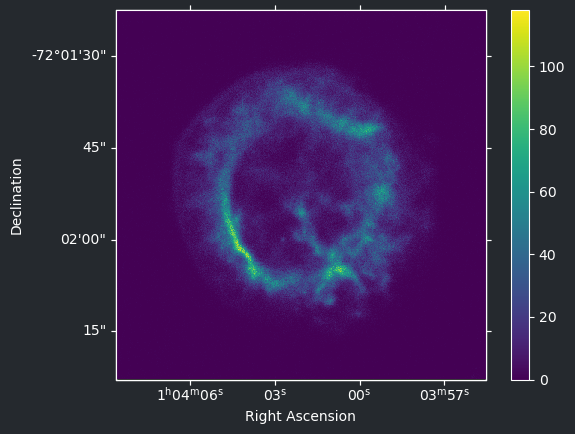

In [10]:
stacked.plot(cmap="viridis", add_cbar=True);

## PSF

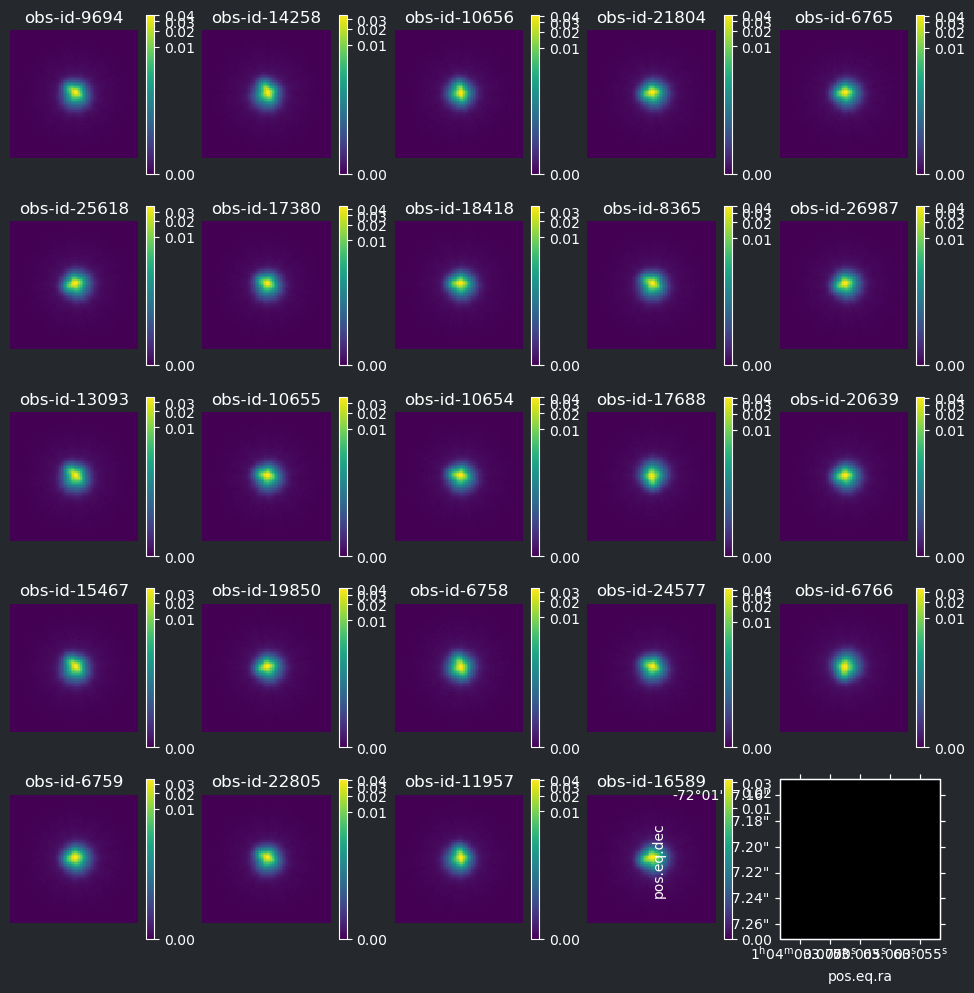

In [11]:
wcs = datasets[f"obs-id-{obs_id_ref}"]["psf"].geom.wcs

fig, axes = plt.subplots(
    ncols=5,
    nrows=5,
    subplot_kw={"projection": wcs},
    figsize=(12, 12)
)

for ax, (name, dataset) in zip(axes.flat, datasets.items()):
    psf = dataset["psf"]
    psf.plot(ax=ax, cmap="viridis", add_cbar=True, stretch="log", vmin=0)
    ax.set_title(f"{name}")
    ax.axis("off")

In [12]:
def to_jolideco_dataset(maps, dtype=np.float32):
    """Convert Gammapy maps to Jolideco dataset."""
    return {
        "counts": maps["counts"].data.astype(dtype),
        "background": maps["background"].data.astype(dtype),
        "psf": {"e0102": maps["psf"].data.astype(dtype)},
        "exposure": maps["exposure"].data.astype(dtype),
    }

In [13]:
datasets_jolideco = {name: to_jolideco_dataset(maps) for name, maps in datasets.items()}

## Run Jolideco

In [14]:
gmm = GaussianMixtureModel.from_registry("jwst-cas-a-v0.1")
gmm.meta.stride = 4
print(gmm)

GaussianMixtureModel
--------------------

  type                  : jwst-cas-a-v0.1



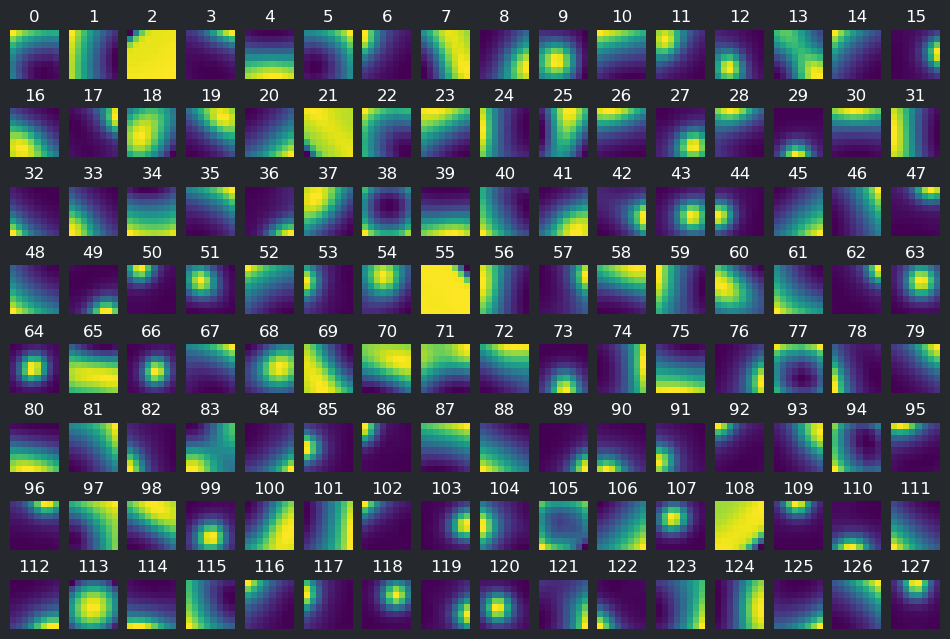

In [15]:
gmm.plot_mean_images(ncols=16, figsize=(12, 8))

In [16]:
patch_prior = GMMPatchPrior(
    gmm=gmm,
    cycle_spin=True,
    cycle_spin_subpix=True,
    norm=IdentityImageNorm(),
    device=device,
)


shape = datasets_jolideco[f"obs-id-{obs_id_ref}"]["counts"].shape
flux_init = np.random.gamma(10, size=shape).astype(np.float32) / 100

component = SpatialFluxComponent.from_numpy(
    flux=flux_init,
    prior=patch_prior,
    use_log_flux=True,
    upsampling_factor=2,
)


components = FluxComponents()
components["e0102"] = component

print(components)

FluxComponents
--------------

  e0102                 : 

    use_log_flux        : True
    upsampling_factor   : 2
    frozen              : False
    prior               : 

      type              : gmm-patches
      stride            : 4
      cycle_spin        : True
      cycle_spin_subpix : True
      jitter            : False
      gmm               : 

        type            : jwst-cas-a-v0.1

      norm              : 

        type            : identity

      patch_norm        : 

        type            : std-subtract-mean

      device            : cpu





In [17]:
calibrations = NPredCalibrations()

for name in datasets_jolideco:
    calibration = NPredCalibration(background_norm=1., frozen=False)
    calibrations[name] = calibration


calibrations[f"obs-id-{obs_id_ref}"].shift_xy.requires_grad = False

print(calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-14258          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-10656          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-21804          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-6765           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-25618          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-17380       

In [18]:
deconvolve = MAPDeconvolver(n_epochs=250, learning_rate=0.1, beta=1., device=device, optimizer="sgd")
print(deconvolve)

MAPDeconvolver
--------------

  n_epochs              : 250
  beta                  : 1.000
  learning_rate         : 0.100
  compute_error         : False
  stop_early            : False
  stop_early_n_average  : 10
  display_progress      : True
  device                : cpu
  optimizer             : sgd



In [19]:
datasets_train = split_datasets_validation(datasets_jolideco, n_validation=0)

In [20]:
result = deconvolve.run(
    components=components,
    calibrations=calibrations,
    **datasets_train,
)
result.write(filename_jolideco_result, overwrite=True)

In [21]:
result = MAPDeconvolverResult.read(filename_jolideco_result)

INFO:jolideco.utils.io.fits:Reading ../../results/e0102-broadband/jolideco/e0102-broadband-result-jolideco.fits


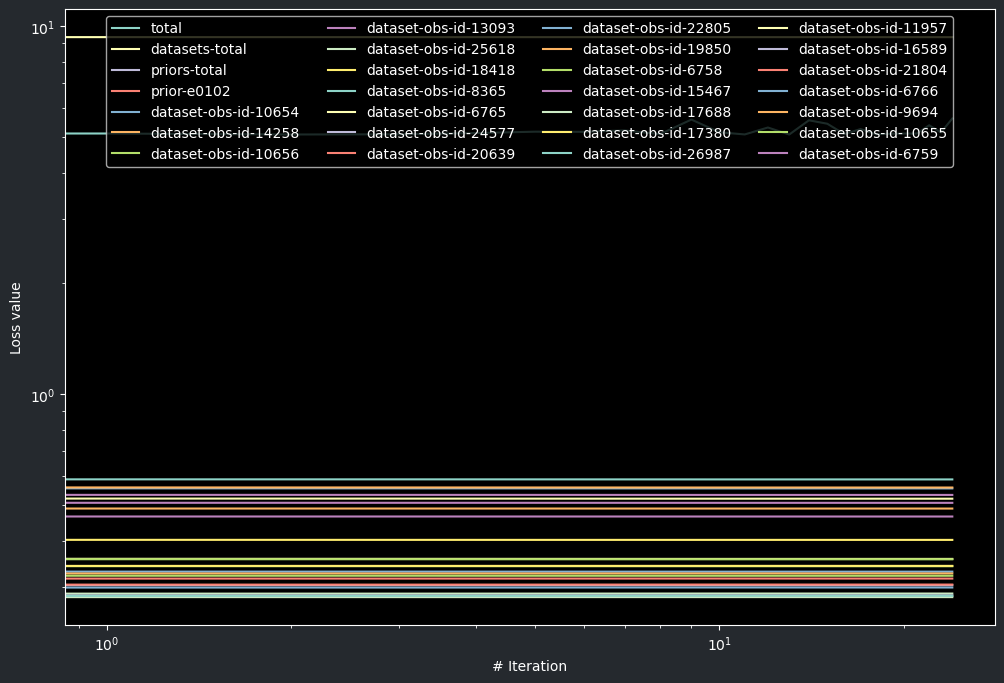

In [22]:
plt.figure(figsize=(12, 8))
result.plot_trace_loss()
plt.legend(loc="upper center", ncols=4)

## Results

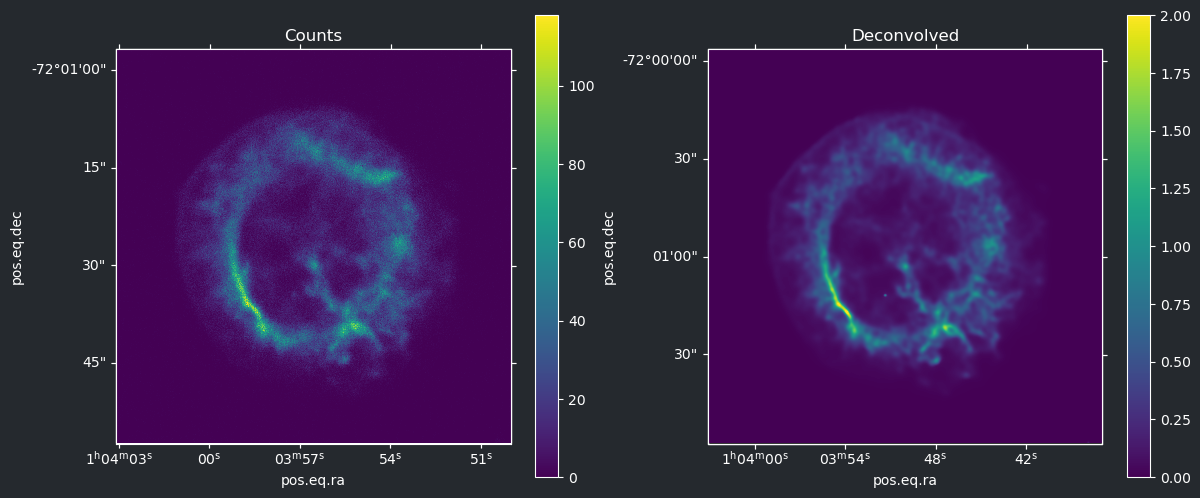

In [41]:
counts = np.sum([_["counts"] for _ in datasets_jolideco.values()], axis=0)

fig, axes = plt.subplots(
    ncols=2,
    subplot_kw={"projection": wcs},
    figsize=(14, 6)
)

norm = simple_norm(
    counts,
    min_cut=0,
    max_cut=2,
    stretch="linear",
    power=1.,
)



im = axes[0].imshow(counts, origin="lower", interpolation="None")
axes[0].set_title("Counts")
plt.colorbar(im);

im = axes[1].imshow(result.components.flux_upsampled_total_numpy, origin="lower", norm=norm, interpolation="gaussian")
axes[1].set_title("Deconvolved");
plt.colorbar(im);
#plt.savefig("/Users/adonath/Desktop/deconvolved.png", dpi=300)


In [24]:
print(calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-14258          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-10656          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-21804          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-6765           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-25618          : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-17380       

## Residuals

## Predicted Counts

In [25]:
geom = datasets[f"obs-id-{obs_id_ref}"]["counts"].geom

In [26]:
npreds = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds[name] =  Map.from_geom(data=npred, geom=geom)
    

npreds_calibrated = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
        calibration=result.calibrations[name]
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds_calibrated[name] = Map.from_geom(data=npred, geom=geom)
    

/Users/adonath/software/mambaforge/envs/jolideco-fermi-examples/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [27]:
npred_stacked = Map.from_geom(geom=geom)

for npred in npreds_calibrated.values():
    npred_stacked.stack(npred)


npred_stacked.write(filename_npred_stacked, overwrite=True)

In [28]:
path = Path("../..")

with (path / "config/config-e0102.yaml").open("r") as fh:
    config = yaml.safe_load(fh)

obs_ids = config["chandra-data"]["obs_ids"]

In [29]:
rows = []

In [30]:
for obs_id in obs_ids:
    filename = path / f"data/{obs_id}" / "oif.fits"
    table = Table.read(filename)
    exposure = table.meta["EXPOSURE"] * u.s
    date = parser.parse(table.meta["DATE-OBS"])
    row = [obs_id, date, round(exposure.to_value("ks"), 1)]
    rows.append(row)

In [31]:
obs_table = Table(rows=rows, names=["obs_id", "date", "exposure"])

In [32]:
obs_table.sort("date")
obs_ids_sorted = obs_table["obs_id"]

## Residuals

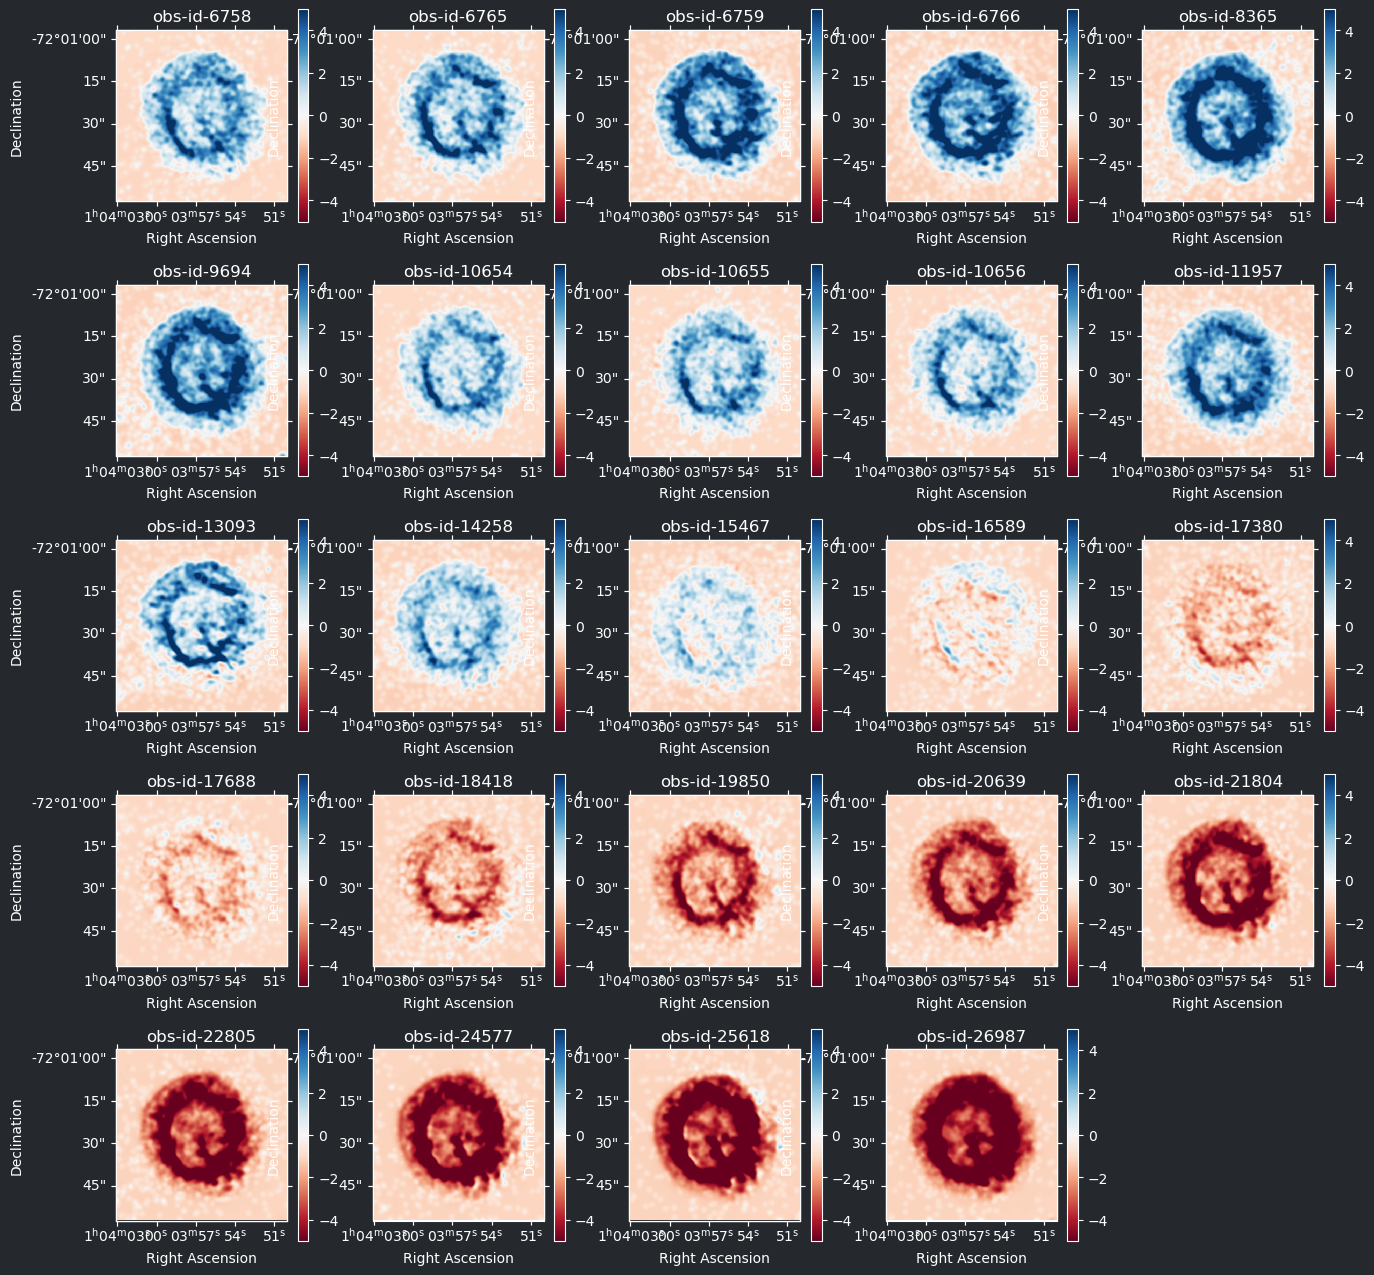

In [34]:
fig, axes = plt.subplots(
    ncols=5,
    nrows=5,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(16, 16)
)

SMOOTH_WIDTH = 5

norm_factor = np.pi * SMOOTH_WIDTH**2


for obs_id, ax in zip_longest(obs_ids_sorted, axes.flat):

    if obs_id is None:
        ax.set_visible(False)
        continue

    name = f"obs-id-{obs_id}"    
    dataset = datasets[name]
    counts = dataset["counts"].sum_over_axes(keepdims=False)
    npred = npreds[name]
    
    diff = (counts - npred).smooth(SMOOTH_WIDTH) * norm_factor

    residuals = diff / np.sqrt(npred.smooth(SMOOTH_WIDTH) * norm_factor)

    residuals.plot(ax=ax, vmin=-5, vmax=5, cmap="RdBu", add_cbar=True)
    ax.set_title(f"{name}")

## Residuals with Correction

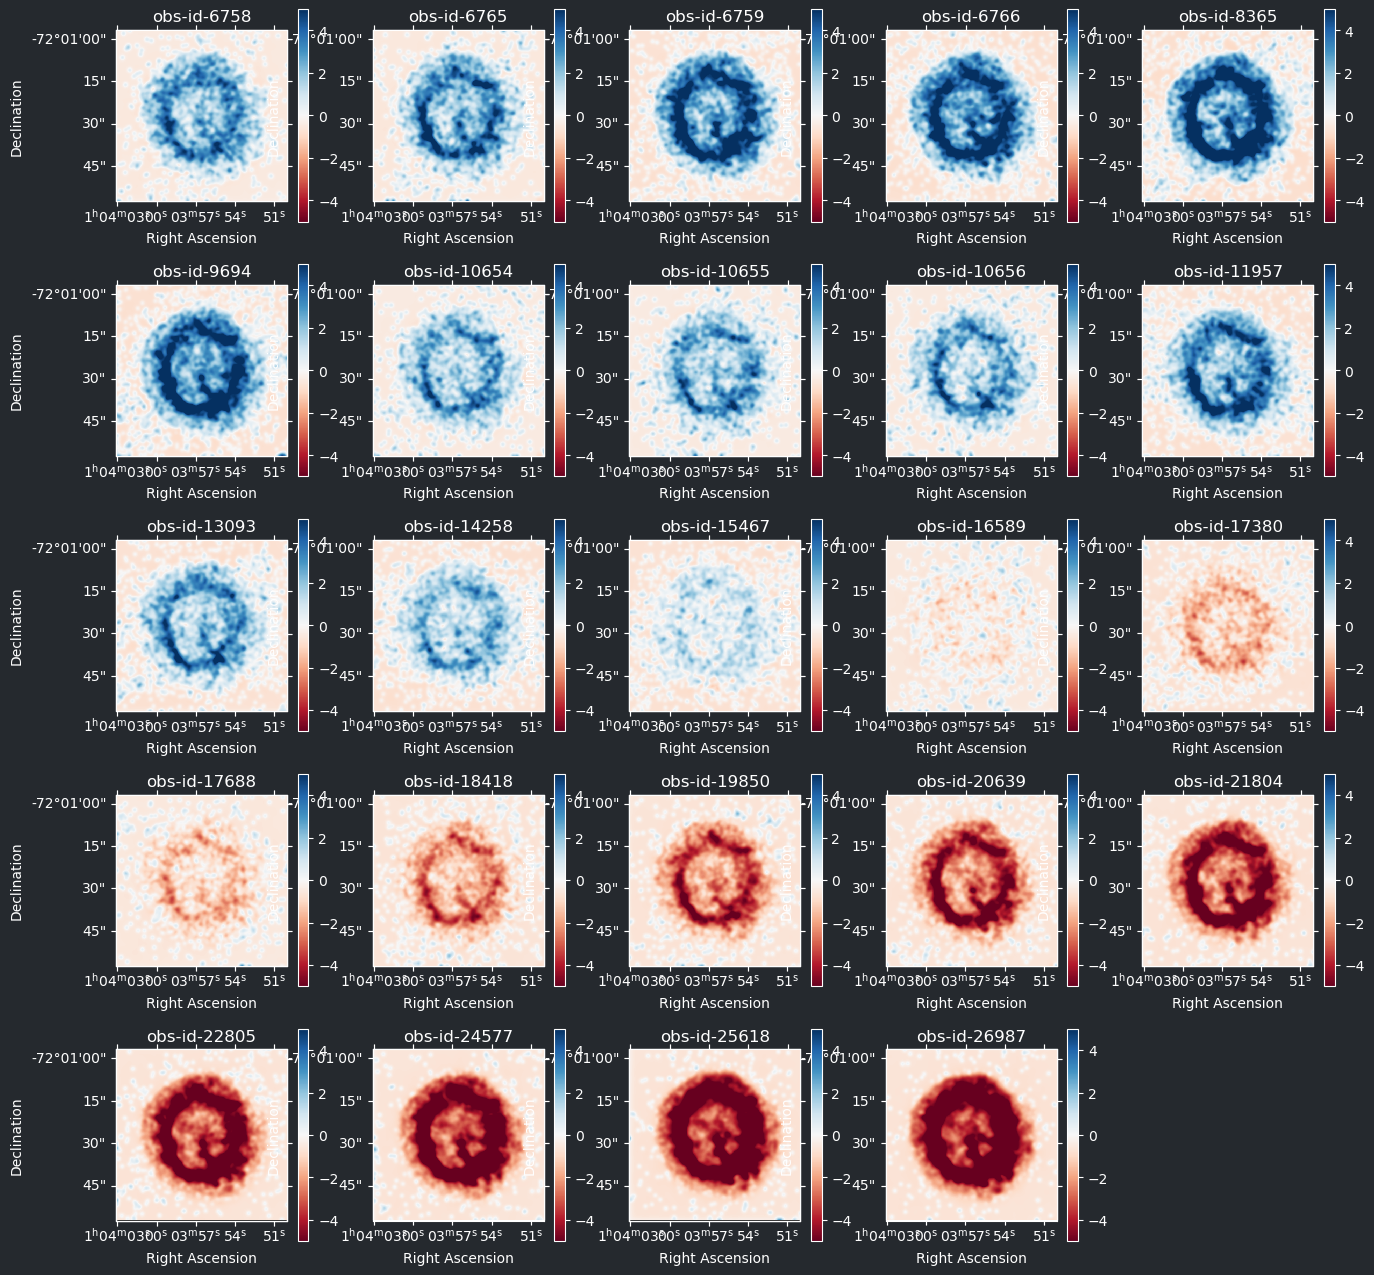

In [35]:
fig, axes = plt.subplots(
    ncols=5,
    nrows=5,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(16, 16)
)


for obs_id, ax in zip_longest(obs_ids_sorted, axes.flat):

    if obs_id is None:
        ax.set_visible(False)
        continue

    name = f"obs-id-{obs_id}"    
        
    dataset = datasets[name]
    counts = dataset["counts"].sum_over_axes(keepdims=False)
    npred = npreds_calibrated[name]
       
    diff = (counts - npred).smooth(SMOOTH_WIDTH) * norm_factor

    residuals = diff / np.sqrt(npred.smooth(SMOOTH_WIDTH) * norm_factor)
    
    residuals.plot(ax=ax, vmin=-5, vmax=5, cmap="RdBu", add_cbar=True)
    ax.set_title(f"{name}")

In [36]:
print(result.calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : -0.667
    shift_y             : -1.404
    background_norm     : 0.089
    frozen              : False

  obs-id-14258          : 

    shift_x             : 1.364
    shift_y             : -0.499
    background_norm     : 0.000
    frozen              : False

  obs-id-10656          : 

    shift_x             : -0.996
    shift_y             : -1.003
    background_norm     : 0.013
    frozen              : False

  obs-id-21804          : 

    shift_x             : -3.723
    shift_y             : 0.747
    background_norm     : 0.000
    frozen              : False

  obs-id-6765           : 

    shift_x             : -1.133
    shift_y             : -2.034
    background_norm     : 0.074
    frozen              : False

  obs-id-25618          : 

    shift_x             : -8.110
    shift_y             : -4.736
    background_norm     : 0.000
    frozen              : False

  obs-id-17